# 1. Import libraries

In [17]:
import pandas as pd
import numpy as np

import fastf1

import sys
sys.path.append('../')

from src.race_prediction_model.extract import *
from src.race_prediction_model.feature_engineering import add_features_to_results
from src.eda import * # Revisar qué funciones necesito de aquí

# Config less verbosity
fastf1.set_log_level('ERROR')

# 2. Data loading

The dataset analyzed in this study consists of a table recording the results of all Formula 1 races from the 2010 season to the present.  

Throughout Formula 1 history, regulations have undergone constant modifications, driven by both technological advancements and the pursuit of greater on-track safety. These changes have led to substantial differences in race characteristics and car performance depending on the era.  

For example, in 2005, tire changes during races were banned, except in cases of emergency or adverse weather conditions. In 2007, Michelin left the championship, leaving Bridgestone as the sole tire supplier, while in 2011, this role was taken over by Pirelli, which remains the official supplier today. In 2010, refueling was eliminated, forcing teams to start races with the total amount of fuel needed to complete them. Additionally, in 2011, the DRS system was introduced to facilitate overtaking, and in 2014, hybrid engines were implemented, marking the beginning of a new technological era.  

These examples are just a few of the many regulatory changes that have occurred, but they illustrate how cars and competition conditions have evolved radically over the past 15 years. As a result, the outcomes of races from older eras are not very representative of the current situation.  

For this analysis, we have selected 2010 as the starting point, as it marks the beginning of a significant era with the elimination of refueling—a change that profoundly impacted race strategy. Additionally, 2010 introduced a new scoring system, very similar to the current one, which placed greater emphasis on consistent results and increased the gaps between the points awarded to the top finishers. While we could have chosen 2014, coinciding with the start of the hybrid era, we believe that including data from 2010 provides a larger volume of information without losing contextual relevance.

### Data extraction

#### Races

We load the dataframe containing the races. If it doesn't exist, we proceed with its extraction.

In [18]:
try:
    df_races = pd.read_csv('../data/output/races.csv')

except FileNotFoundError:
    print("Data not found: Extracting data...")
    df_races = extract_races_dataframe(2010, end=2024, save=True)

In [29]:
df_races.sample(5)

,season,round,circuitId
153,2017,18,rodriguez
190,2019,14,monza
20,2011,2,sepang
66,2013,9,nurburgring
205,2020,8,monza


We have 305 races from 2010 to 2024. Now we need to extract the results of each one. That is, for each Grand Prix, we need the results of each driver.

In [25]:
try:
    df_results = pd.read_csv('../data/output/results.csv', index_col=0)

except FileNotFoundError:
    print("Data not found: Extracting data...")
    # Caution! This extraction takes A LOT of time. It's recommended to manually extract each season one by one.
    # df_results = extract_results_dataframe(df_races, save=True)[0]

# 3. Data description

In [30]:
df_results.head()

,DriverId,TeamId,Position,GridPosition,Time,Status,Points,season,round,circuitId
8,alonso,ferrari,1.0,3.0,0.000,Finished,25.0,2010,1,bahrain
7,massa,ferrari,2.0,2.0,16.099,Finished,18.0,2010,1,bahrain
2,hamilton,mclaren,3.0,4.0,23.182,Finished,15.0,2010,1,bahrain
5,vettel,red_bull,4.0,1.0,38.799,Finished,12.0,2010,1,bahrain
4,rosberg,mercedes,5.0,5.0,40.213,Finished,10.0,2010,1,bahrain


The dataset has been obtained using the `fastf1` library, which combines data from various sources, including the Ergast API, the F1 LiveTiming API, and its own backend, to collect detailed and accurate information. [See FastF1 Documentation](https://docs.fastf1.dev/).

For building a predictive model, a set of key variables has been gathered to provide critical insights into driver and team performance in races. These variables are:  

- **`DriverId`**: Unique identifier for the driver.  

- **`TeamId`**: Identifier of the team to which the driver belongs. 

- **`Position`**: Driver's final position in the race.  

- **`GridPosition`**: Starting position on the grid.  

- **`Time`**: Time difference with which the driver crosses the finish line relative to the leader.  

- **`Status`**: Final status of the driver in the race, indicating whether they finished or the reason for their retirement.  

- **`Points`**: Points earned by the driver in the race.  

- **`season`**: Season in which the Grand Prix took place.  

- **`round`**: Round number within the season corresponding to the Grand Prix.  

- **`circuitId`**: Unique identifier of the circuit where the race was held.  

This set of variables provides a solid foundation for exploring patterns, evaluating performance, and making accurate predictions about future competitions.  

Additionally, *feature engineering* will be applied to create and add key features that capture relevant information and enhance the predictive model's performance.

In [31]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6436 entries, 8 to 11
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DriverId      6436 non-null   object 
 1   TeamId        6436 non-null   object 
 2   Position      6433 non-null   float64
 3   GridPosition  6433 non-null   float64
 4   Time          6392 non-null   float64
 5   Status        6436 non-null   object 
 6   Points        6436 non-null   float64
 7   season        6436 non-null   int64  
 8   round         6436 non-null   int64  
 9   circuitId     6436 non-null   object 
dtypes: float64(4), int64(2), object(4)
memory usage: 553.1+ KB


We see that there are some null values in `Time` and `GridPosition`/`Position`, although not many. Let's analyze them.

`GridPosition`

In [34]:
df_results[df_results['GridPosition'].isna()]

,DriverId,TeamId,Position,GridPosition,Time,Status,Points,season,round,circuitId
9,mazepin,haas,NaN,NaN,167.527,Illness,0.0,2021,22,yas_marina
47,mick_schumacher,haas,NaN,NaN,191.742,Withdrew,0.0,2022,2,jeddah
18,stroll,aston_martin,NaN,NaN,187.603,Withdrew,0.0,2023,15,marina_bay


In the case of `GridPosition`, the three entries we have correspond to drivers who did not qualify for the race, as we can confirm by their status. We can directly remove these entries.

We also verified that these entries coincide with the null values in `Position`.

As an observation, we see that they have a `Time` value despite not having competed. This is because, during data extraction, a `Time` value higher than that of the last classified driver is assigned to those who did not finish the race.

In [35]:
df_results.dropna(subset=['GridPosition'], inplace=True)

`Time`

In [36]:
df_results[df_results['Time'].isna()].shape

(44, 10)

In [37]:
df_results[df_results['Time'].isna()].sort_values(by='Position').head()

,DriverId,TeamId,Position,GridPosition,Time,Status,Points,season,round,circuitId
9,raikkonen,lotus_f1,6.0,4.0,NaN,Finished,8.0,2012,19,americas
3,ricciardo,mclaren,7.0,6.0,NaN,Finished,6.0,2021,1,bahrain
10,grosjean,lotus_f1,7.0,8.0,NaN,Finished,6.0,2012,19,americas
55,sainz,ferrari,8.0,8.0,NaN,Finished,4.0,2021,1,bahrain
17,vergne,toro_rosso,8.0,16.0,NaN,Finished,4.0,2012,16,yeongam


In the case of `Time`, the null values appear in some records from certain races. This does not seem too relevant since there are only 44 entries, and the highest position affected is sixth place, which does not impact podiums or victories.  

In any case, this would only affect a regression model specifically predicting finishing times. However, since we will be removing this column in our model, it will not be an issue.

### Categorical variables

In [38]:
df_results.describe(include='O').T

,count,unique,top,freq
DriverId,6433,80,hamilton,304
TeamId,6433,23,ferrari,610
Status,6433,78,Finished,3305
circuitId,6433,35,silverstone,338


#### `DriverId`

In [39]:
df_results['DriverId'].unique()

array(['alonso', 'massa', 'hamilton', 'vettel', 'rosberg',
       'michael_schumacher', 'button', 'webber', 'liuzzi', 'barrichello',
       'kubica', 'sutil', 'alguersuari', 'hulkenberg', 'kovalainen',
       'buemi', 'trulli', 'rosa', 'bruno_senna', 'glock', 'petrov',
       'kobayashi', 'grassi', 'chandhok', 'yamamoto', 'heidfeld', 'klien',
       'resta', 'ambrosio', 'maldonado', 'perez', 'karthikeyan',
       'ricciardo', 'raikkonen', 'vergne', 'pic', 'grosjean', 'gutierrez',
       'bottas', 'jules_bianchi', 'chilton', 'garde', 'kevin_magnussen',
       'kvyat', 'ericsson', 'lotterer', 'stevens', 'nasr', 'sainz',
       'max_verstappen', 'merhi', 'rossi', 'jolyon_palmer', 'wehrlein',
       'haryanto', 'vandoorne', 'ocon', 'giovinazzi', 'stroll', 'gasly',
       'brendon_hartley', 'leclerc', 'sirotkin', 'norris', 'albon',
       'russell', 'latifi', 'aitken', 'pietro_fittipaldi', 'tsunoda',
       'mick_schumacher', 'mazepin', 'zhou', 'de_vries', 'sargeant',
       'piastri', 'law

#### `TeamId`

In [40]:
df_results['TeamId'].unique()

array(['ferrari', 'mclaren', 'red_bull', 'mercedes', 'force_india',
       'williams', 'renault', 'toro_rosso', 'lotus_racing', 'sauber',
       'hrt', 'virgin', 'lotus_f1', 'marussia', 'caterham', 'manor',
       'haas', 'alfa', 'racing_point', 'alphatauri', 'aston_martin',
       'alpine', 'rb'], dtype=object)

With the teams, we have an issue since some teams are the same but have changed their names over the seasons. Specifically, the following IDs correspond to the same team:

- `ferrari`

- `mclaren`

- `red_bull`

- `mercedes`

- `williams`

- `sauber`, `alfa`

- `force_india`, `racing_point`, `aston_martin`

- `renault`, `lotus_f1`, `alpine`

- `lotus_racing`, `caterham`

- `virgin`, `marussia`, `manor`

- `toro_rosso`, `alphatauri`, `rb`

- `haas`

- `hrt`

We will build a function that replaces the team ID names with the most recent name the team has had.



In [43]:
def team_id_replacement(df):
    
    dc = {
        'sauber': 'alfa',
        'alfa': 'alfa',
        'force_india': 'aston_martin',
        'racing_point': 'aston_martin',
        'renault': 'alpine',
        'lotus_f1': 'alpine',
        'lotus_racing': 'caterham',
        'virgin': 'manor',
        'marussia': 'manor',
        'toro_rosso': 'rb',
        'alphatauri': 'rb'
    }
    df['TeamId'] = df['TeamId'].replace(dc)

team_id_replacement(df_results)

In [44]:
df_results['TeamId'].unique()

array(['ferrari', 'mclaren', 'red_bull', 'mercedes', 'aston_martin',
       'williams', 'alpine', 'rb', 'caterham', 'alfa', 'hrt', 'manor',
       'haas'], dtype=object)

#### `circuitId`

In [45]:
df_results['circuitId'].unique()

array(['bahrain', 'albert_park', 'sepang', 'shanghai', 'catalunya',
       'monaco', 'istanbul', 'villeneuve', 'valencia', 'silverstone',
       'hockenheimring', 'hungaroring', 'spa', 'monza', 'marina_bay',
       'suzuka', 'yeongam', 'interlagos', 'yas_marina', 'nurburgring',
       'buddh', 'americas', 'red_bull_ring', 'sochi', 'rodriguez', 'baku',
       'ricard', 'mugello', 'portimao', 'imola', 'zandvoort', 'losail',
       'jeddah', 'miami', 'vegas'], dtype=object)

Everything here looks fine.

### Numerical variables

Veamos una descripción de las estadísticas básicas de las variables numéricas.

In [46]:
df_results.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Position,6433.0,11.11,6.19,1.0,6.00,11.00,16.00,24.00
GridPosition,6433.0,10.87,6.24,0.0,6.00,11.00,16.00,24.00
Time,6389.0,105.68,72.67,0.0,35.05,98.32,178.14,248.84
Points,6433.0,4.81,7.14,0.0,0.00,0.00,8.00,50.00
season,6433.0,2016.97,4.42,2010.0,2013.00,2017.00,2021.00,2024.00
round,6433.0,10.70,5.96,1.0,6.00,11.00,16.00,24.00


Veamos la matriz de correlación

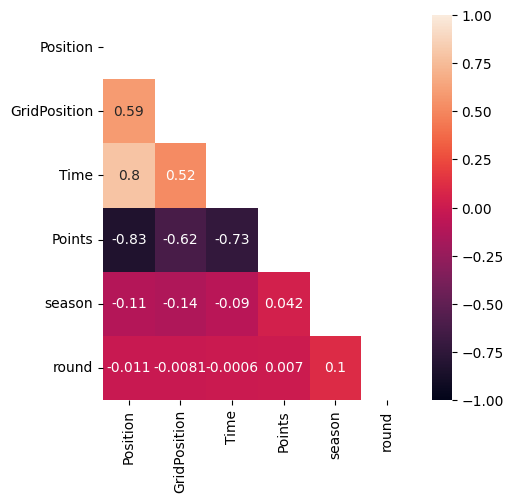

In [47]:
plot_correlation_matrix(df_results)

We see quite logical things:

* `season` and `round` have no correlation with the other variables.

* `GridPosition` has a moderate to strong correlation with `Position`, indicating that a better starting grid position is usually related to a better position in the race.

* `Time` has a very strong correlation with `Position` and moderate correlation with `GridPosition`, the latter inherited from the previous correlation.

* `Points` has a strong negative correlation with `Position` (and, consequently, with `GridPosition` and `Time`). This makes sense because a better result corresponds to more points.

# 4. Feature engineering

If the race has not occurred, we cannot use information that depends on the results of that specific race, such as time or final points. In that case, you should rely exclusively on prior or contextual information that is available before the race. Here's how to approach the problem:

### Redefine the feature set
We must build our predictions based on historical and contextual data available before the race. For this reason, we will add the following features:

- `Winner`: Determine if the driver won the race (Position 1)

- `Podium`: Determine if the driver finished on the podium (Position 1, 2, or 3)

- `MeanPreviousGrid`: Mean of the driver's grid positions over the previous races.

- `MeanPreviousPosition`: Mean of the driver's finishing positions over the previous races.

- `CurrentDriverPoints`: Cumulative driver points before the race.

- `CurrentDriverWins`: Cumulative race wins before the race.

- `CurrentDriverPodiums`: Cumulative podium finishes before the race.

- `CurrentTeamPoints`: Cumulative team points before the race.

The average variables are calculated using a default window of 3 races.

In [49]:
add_features_to_results(df_results)

In [57]:
df_results.head()

,DriverId,TeamId,Position,GridPosition,Time,Status,Points,season,round,circuitId,Winner,Podium,MeanPreviousGrid,MeanPreviousPosition,CurrentDriverPoints,CurrentDriverWins,CurrentDriverPodiums,CurrentTeamPoints
8,alonso,ferrari,1.0,3.0,0.000,Finished,25.0,2010,1,bahrain,1,1,3.0,1.0,0.0,0,0,0.0
7,massa,ferrari,2.0,2.0,16.099,Finished,18.0,2010,1,bahrain,0,1,2.0,2.0,0.0,0,0,0.0
2,hamilton,mclaren,3.0,4.0,23.182,Finished,15.0,2010,1,bahrain,0,1,4.0,3.0,0.0,0,0,0.0
5,vettel,red_bull,4.0,1.0,38.799,Finished,12.0,2010,1,bahrain,0,0,1.0,4.0,0.0,0,0,0.0
4,rosberg,mercedes,5.0,5.0,40.213,Finished,10.0,2010,1,bahrain,0,0,5.0,5.0,0.0,0,0,0.0


Veamos de nuevo la matriz de correlación con estas nuevas variables

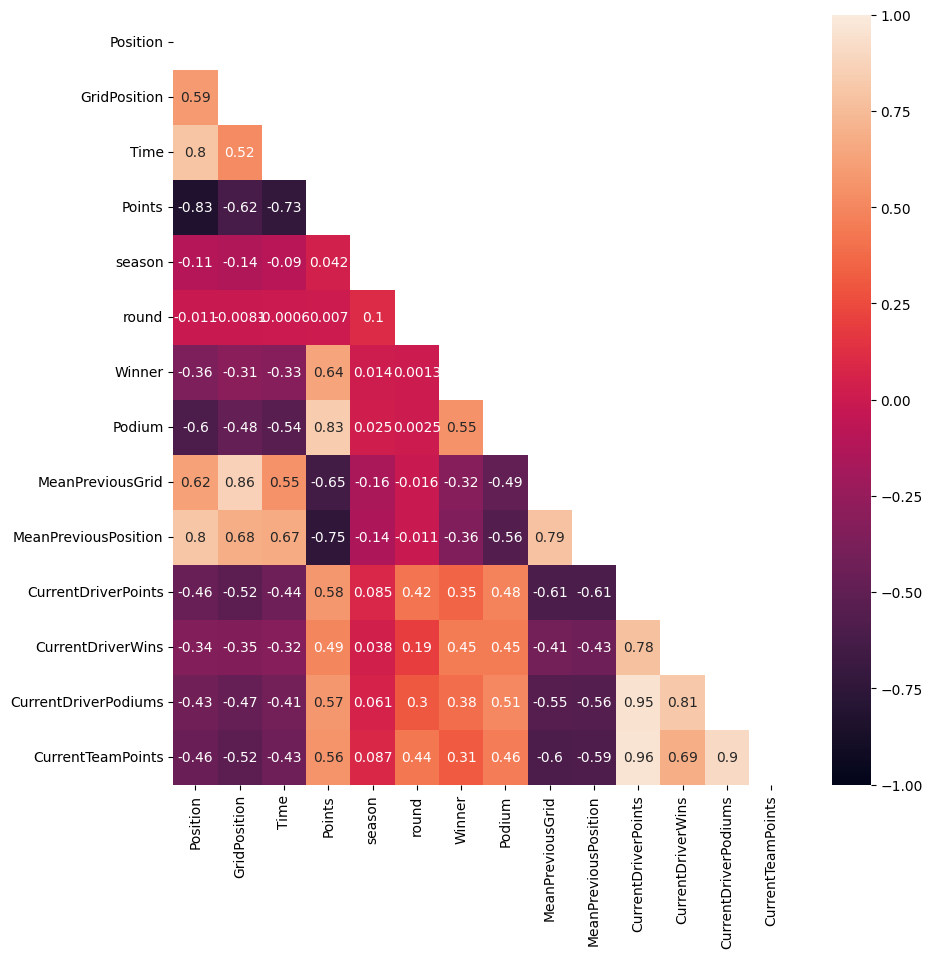

In [58]:
plot_correlation_matrix(df_results, size=(10,10))

Variables with a correlation higher than 0.9 can be considered explained by each other. Thus, we can eliminate some of the generated features.

In particular, we will remove the following variables:

* `season`: It has no correlation with the rest of the variables.

* `CurrentDriverPoints`, `CurrentTeamPoints`: They are explained by the current podiums and victories of the driver, so they are not necessary.

Note: For the classification model, we cannot remove the `round` feature as it is necessary to contextualize the points/victories accumulated throughout the season.

In [59]:
df_results.drop(columns=['season', 'CurrentDriverPoints', 'CurrentTeamPoints'], inplace=True)

In [51]:
df_results.to_csv('../data/output/featured_results.csv')

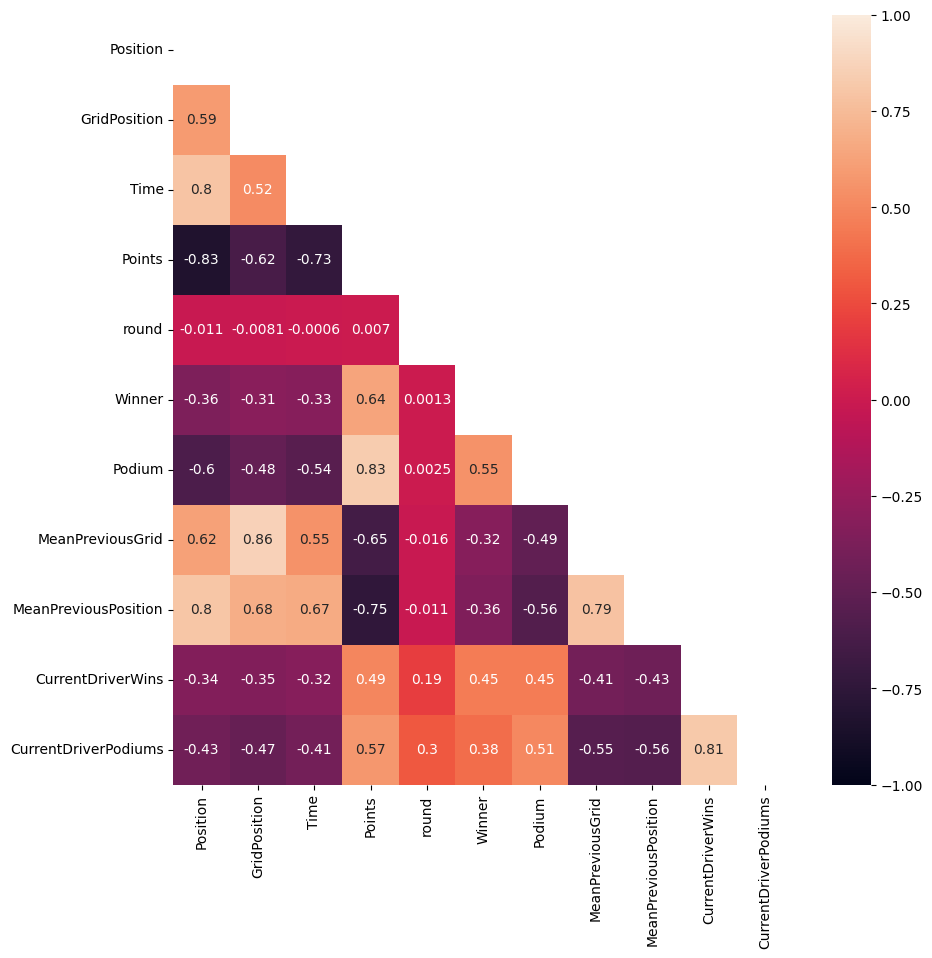

In [61]:
plot_correlation_matrix(df_results, size=(10,10))